In [9]:
import requests

GetCapUrl = 'https://mesonet.agron.iastate.edu/cgi-bin/wms/nexrad/n0r-t.cgi?service=wms&version=1.3.0&request=GetCapabilities'

resp = requests.get(GetCapUrl)
print(resp.text)

<?xml version='1.0' encoding="UTF-8" standalone="no" ?>
<WMS_Capabilities version="1.3.0"  xmlns="http://www.opengis.net/wms"   xmlns:sld="http://www.opengis.net/sld"   xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"   xmlns:ms="http://mapserver.gis.umn.edu/mapserver"   xsi:schemaLocation="http://www.opengis.net/wms http://schemas.opengis.net/wms/1.3.0/capabilities_1_3_0.xsd  http://www.opengis.net/sld http://schemas.opengis.net/sld/1.1.0/sld_capabilities.xsd  http://mapserver.gis.umn.edu/mapserver https://mesonet.agron.iastate.edu/cgi-bin/wms/nexrad/n0r-t.cgi?service=WMS&amp;version=1.3.0&amp;request=GetSchemaExtension">

<!-- MapServer version 7.5-dev OUTPUT=PNG OUTPUT=JPEG SUPPORTS=PROJ SUPPORTS=AGG SUPPORTS=FREETYPE SUPPORTS=CAIRO SUPPORTS=ICONV SUPPORTS=FRIBIDI SUPPORTS=WMS_SERVER SUPPORTS=WMS_CLIENT SUPPORTS=WFS_SERVER SUPPORTS=WFS_CLIENT SUPPORTS=WCS_SERVER SUPPORTS=FASTCGI SUPPORTS=GEOS INPUT=JPEG INPUT=POSTGIS INPUT=OGR INPUT=GDAL INPUT=SHAPEFILE -->

<Service>
  <Name>W

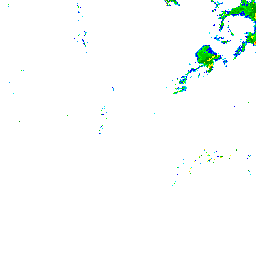

In [17]:
from IPython.core.display import Image, display
GetMapUrlValid = """https://mesonet.agron.iastate.edu/cgi-bin/wms/nexrad/n0r-t.cgi?
SERVICE=WMS
&VERSION=1.3.0
&REQUEST=GetMap
&FORMAT=image/png
&TRANSPARENT=true
&LAYERS=nexrad-n0r-wmst
&TIME=2019-06-15T15:10:00Z
&WIDTH=256
&HEIGHT=256
&CRS=EPSG:3857
&STYLES=
&BBOX=-12523442.714243278,2504688.542848654,-10018754.171394622,5009377.08569731""".replace('\n','')

resp = requests.get(GetMapUrlValid)

display(Image(data=resp.content, format='jpg', unconfined=True))

In [20]:
GetMapUrlInvalid = """https://mesonet.agron.iastate.edu/cgi-bin/wms/nexrad/n0r-t.cgi?
SERVICE=WMS
&VERSION=1.3.0
&REQUEST=GetMap
&FORMAT=image/png
&TRANSPARENT=true
&LAYERS=nexrad-n0r-wmst
&TIME=2019-06-15
&WIDTH=256
&HEIGHT=256
&CRS=EPSG:3857
&STYLES=
&BBOX=-12523442.714243278,2504688.542848654,-10018754.171394622,5009377.08569731""".replace('\n','')

resp = requests.get(GetMapUrlInvalid)
print(resp.text)

<?xml version='1.0' encoding="UTF-8" standalone="no" ?>
<ServiceExceptionReport version="1.3.0" xmlns="http://www.opengis.net/ogc" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.opengis.net/ogc http://schemas.opengis.net/wms/1.3.0/exceptions_1_3_0.xsd">
<ServiceException code="InvalidDimensionValue">
msWMSSetTimePattern: WMS server error. Time value 2019-06-15 given does not match the time format pattern.
</ServiceException>
</ServiceExceptionReport>



Zeitinfo nur für frontend (hidden in getCap with GET parameter runtime substitution: im prinzip reine textoperation)
in mapfile include: (https://github.com/geoadmin/wms-mapfile_include/blob/master/ch.swisstopo.lubis-luftbilder_farbe.map)
```
VALIDATION
        "time" "^[0-9]{8}$"
        "default_time" "99991231"
END
```
=> GET parameter

wms-t (published in getCap): https://github.com/geoadmin/wms-mapfile_include/blob/master/ch.swisstopo.lubis-luftbilder_schraegaufnahmen.map
requires real date in `bgdi_date`
```
    METADATA
     "wms_enable_request" "*"
        "id_attribute_string" "ebkey"
        "wms_timeextent" "1900/9999"
        "wms_timeitem" "bgdi_date"
        "wms_timeformat" "YYYY"
        "wms_extent" "2100000 1050000 2850000 1400000"
END
```